In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import cv2

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  0


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_IR.h5')


In [ ]:
def load_image_custom(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

def show_layers(img_tensor):
    layer_outputs = [layer.output for layer in model.layers[:8]]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)
    first_layer_activation = activations[0]
    layer_names = []
    for layer in model.layers[2:]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations[2:]):
        # This is the number of features (channels) in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        # if not n_cols: n_cols = n_features
        display_grid = np.zeros((size * n_cols, size * images_per_row))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
    plt.show()

In [ ]:
dog = load_image_custom('/content/drive/MyDrive/test_dog_image.jpg')
cat = load_image_custom('/content/drive/MyDrive/test_cat_image.jpg')

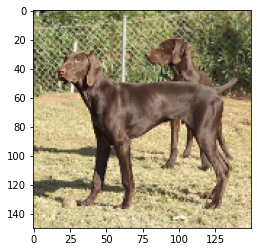

In [ ]:
plt.imshow(dog[0])
plt.show()

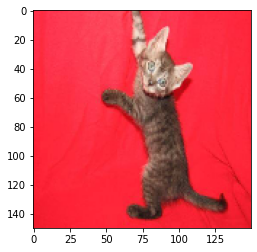

In [ ]:
plt.imshow(cat[0])
plt.show()

1/1 [==============================] - 0s 454ms/step


<ipython-input-6-ca96188834be>:39: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


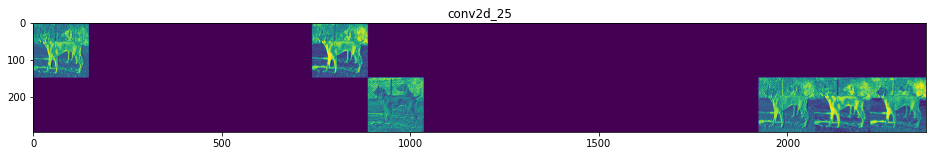

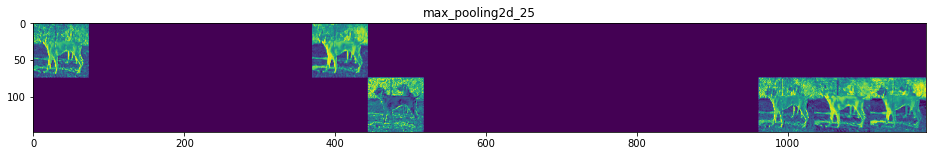

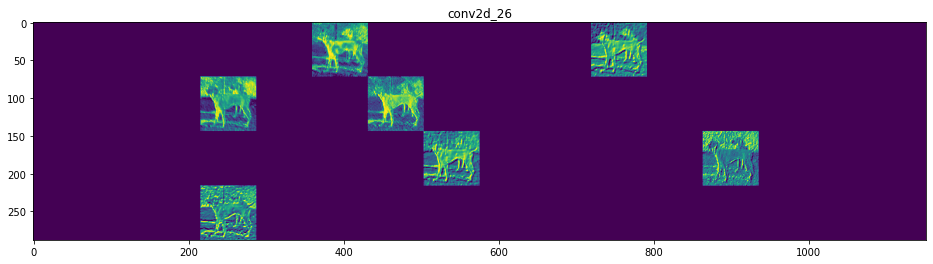

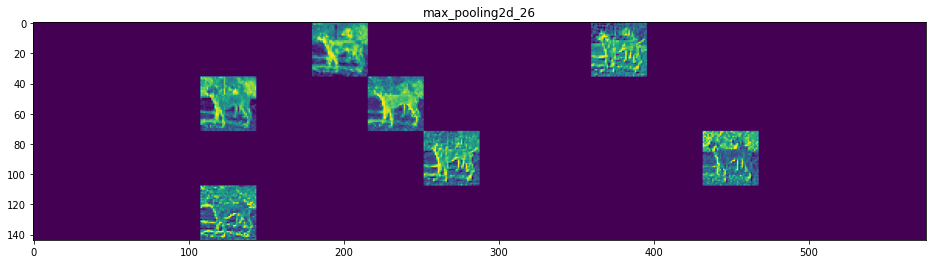

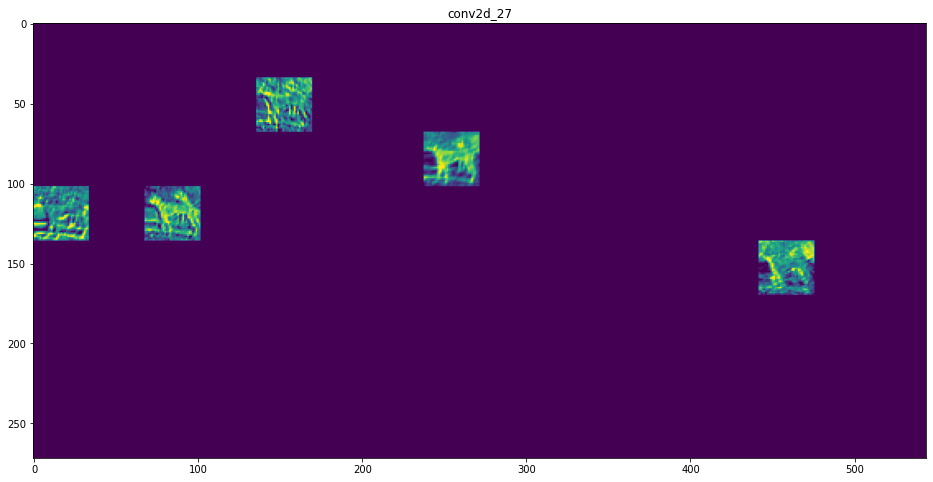

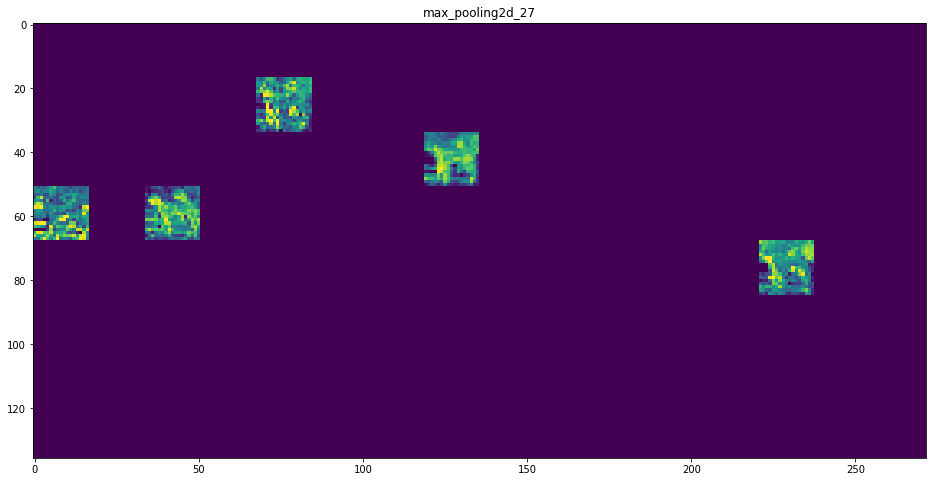

In [ ]:
show_layers(dog)

1/1 [==============================] - 0s 78ms/step


<ipython-input-6-ca96188834be>:39: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


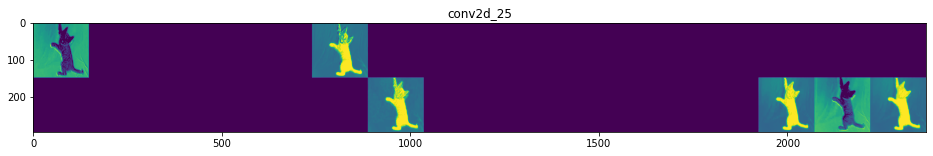

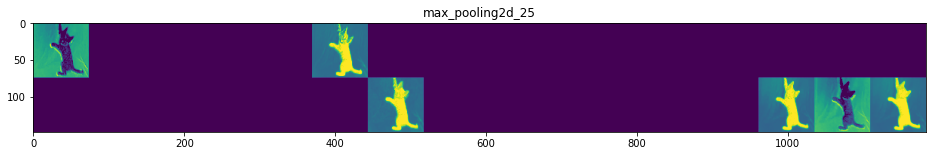

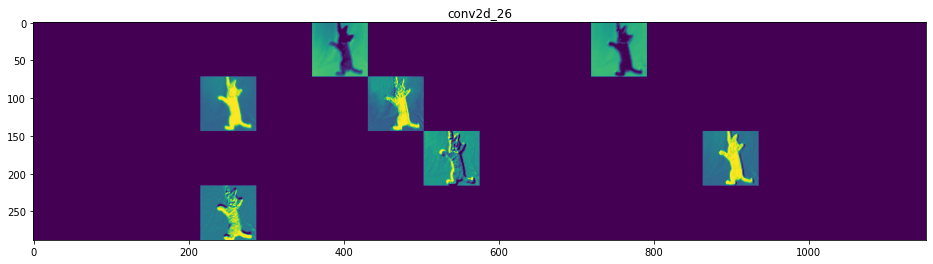

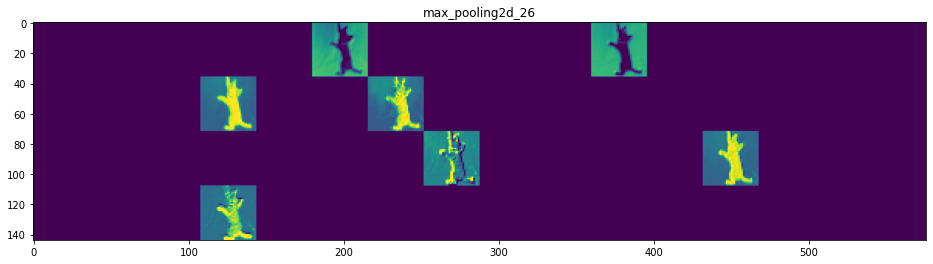

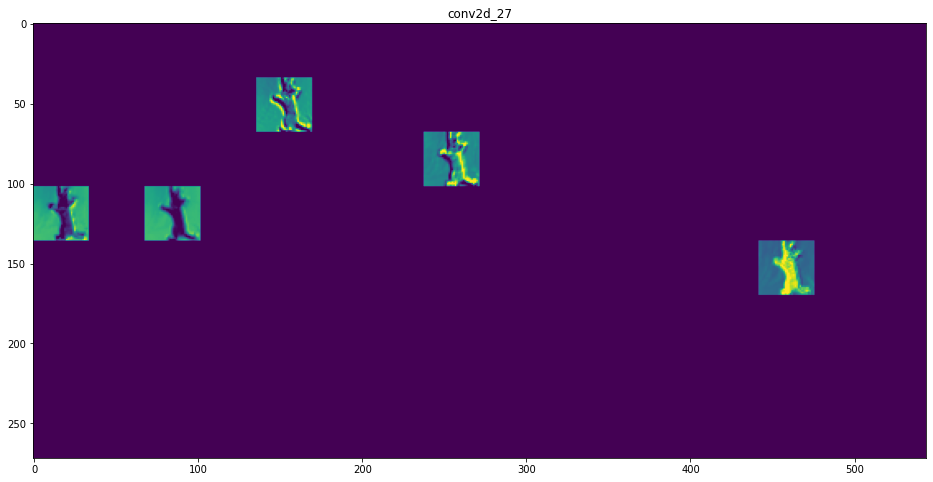

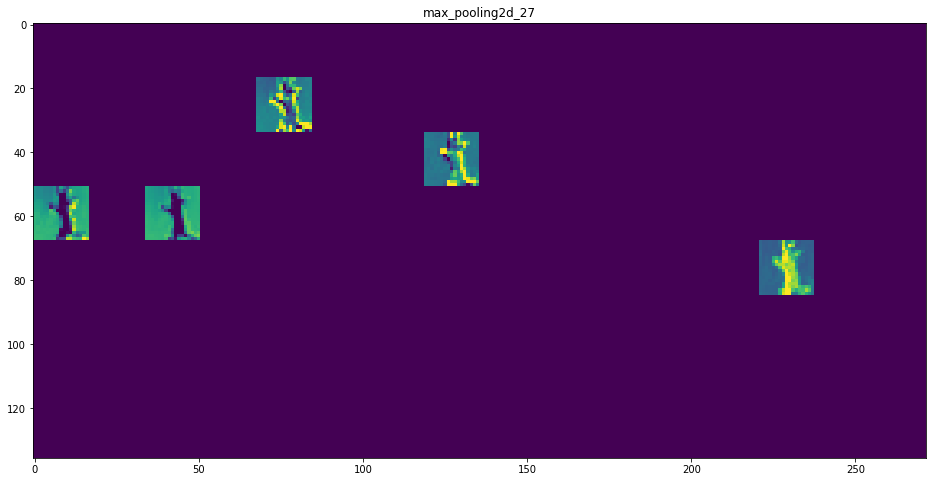

In [ ]:
show_layers(cat)

# Wnioski:
Aktywowane są tylko niektóre maski, identyczne dla kota i psa, duża część masek jest bezczynnie przeliczana.

Dla różnych obrazów wejściowych martwe są te same filtry.

Liczba nie-martwych filtrów: 
  - 6/32
  - 7/64
  - 5/128


In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
#from keras.applications import VGG16
from tensorflow.keras.applications import VGG16
#from keras import backend as K
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

  
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture with this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)


58889256/58889256 [==============================] - 1s 0us/step


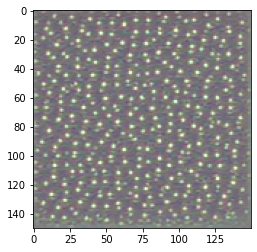

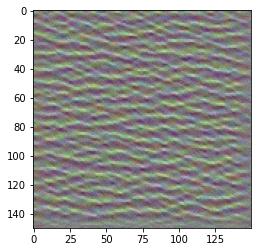

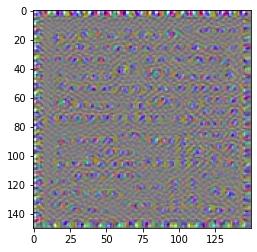

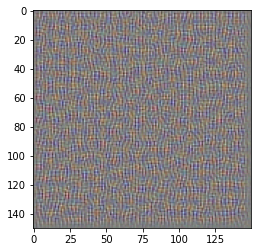

In [ ]:
for i in range(4):
    plt.imshow(generate_pattern('block3_conv1', i))
    plt.show()

Layer name: block1_conv1


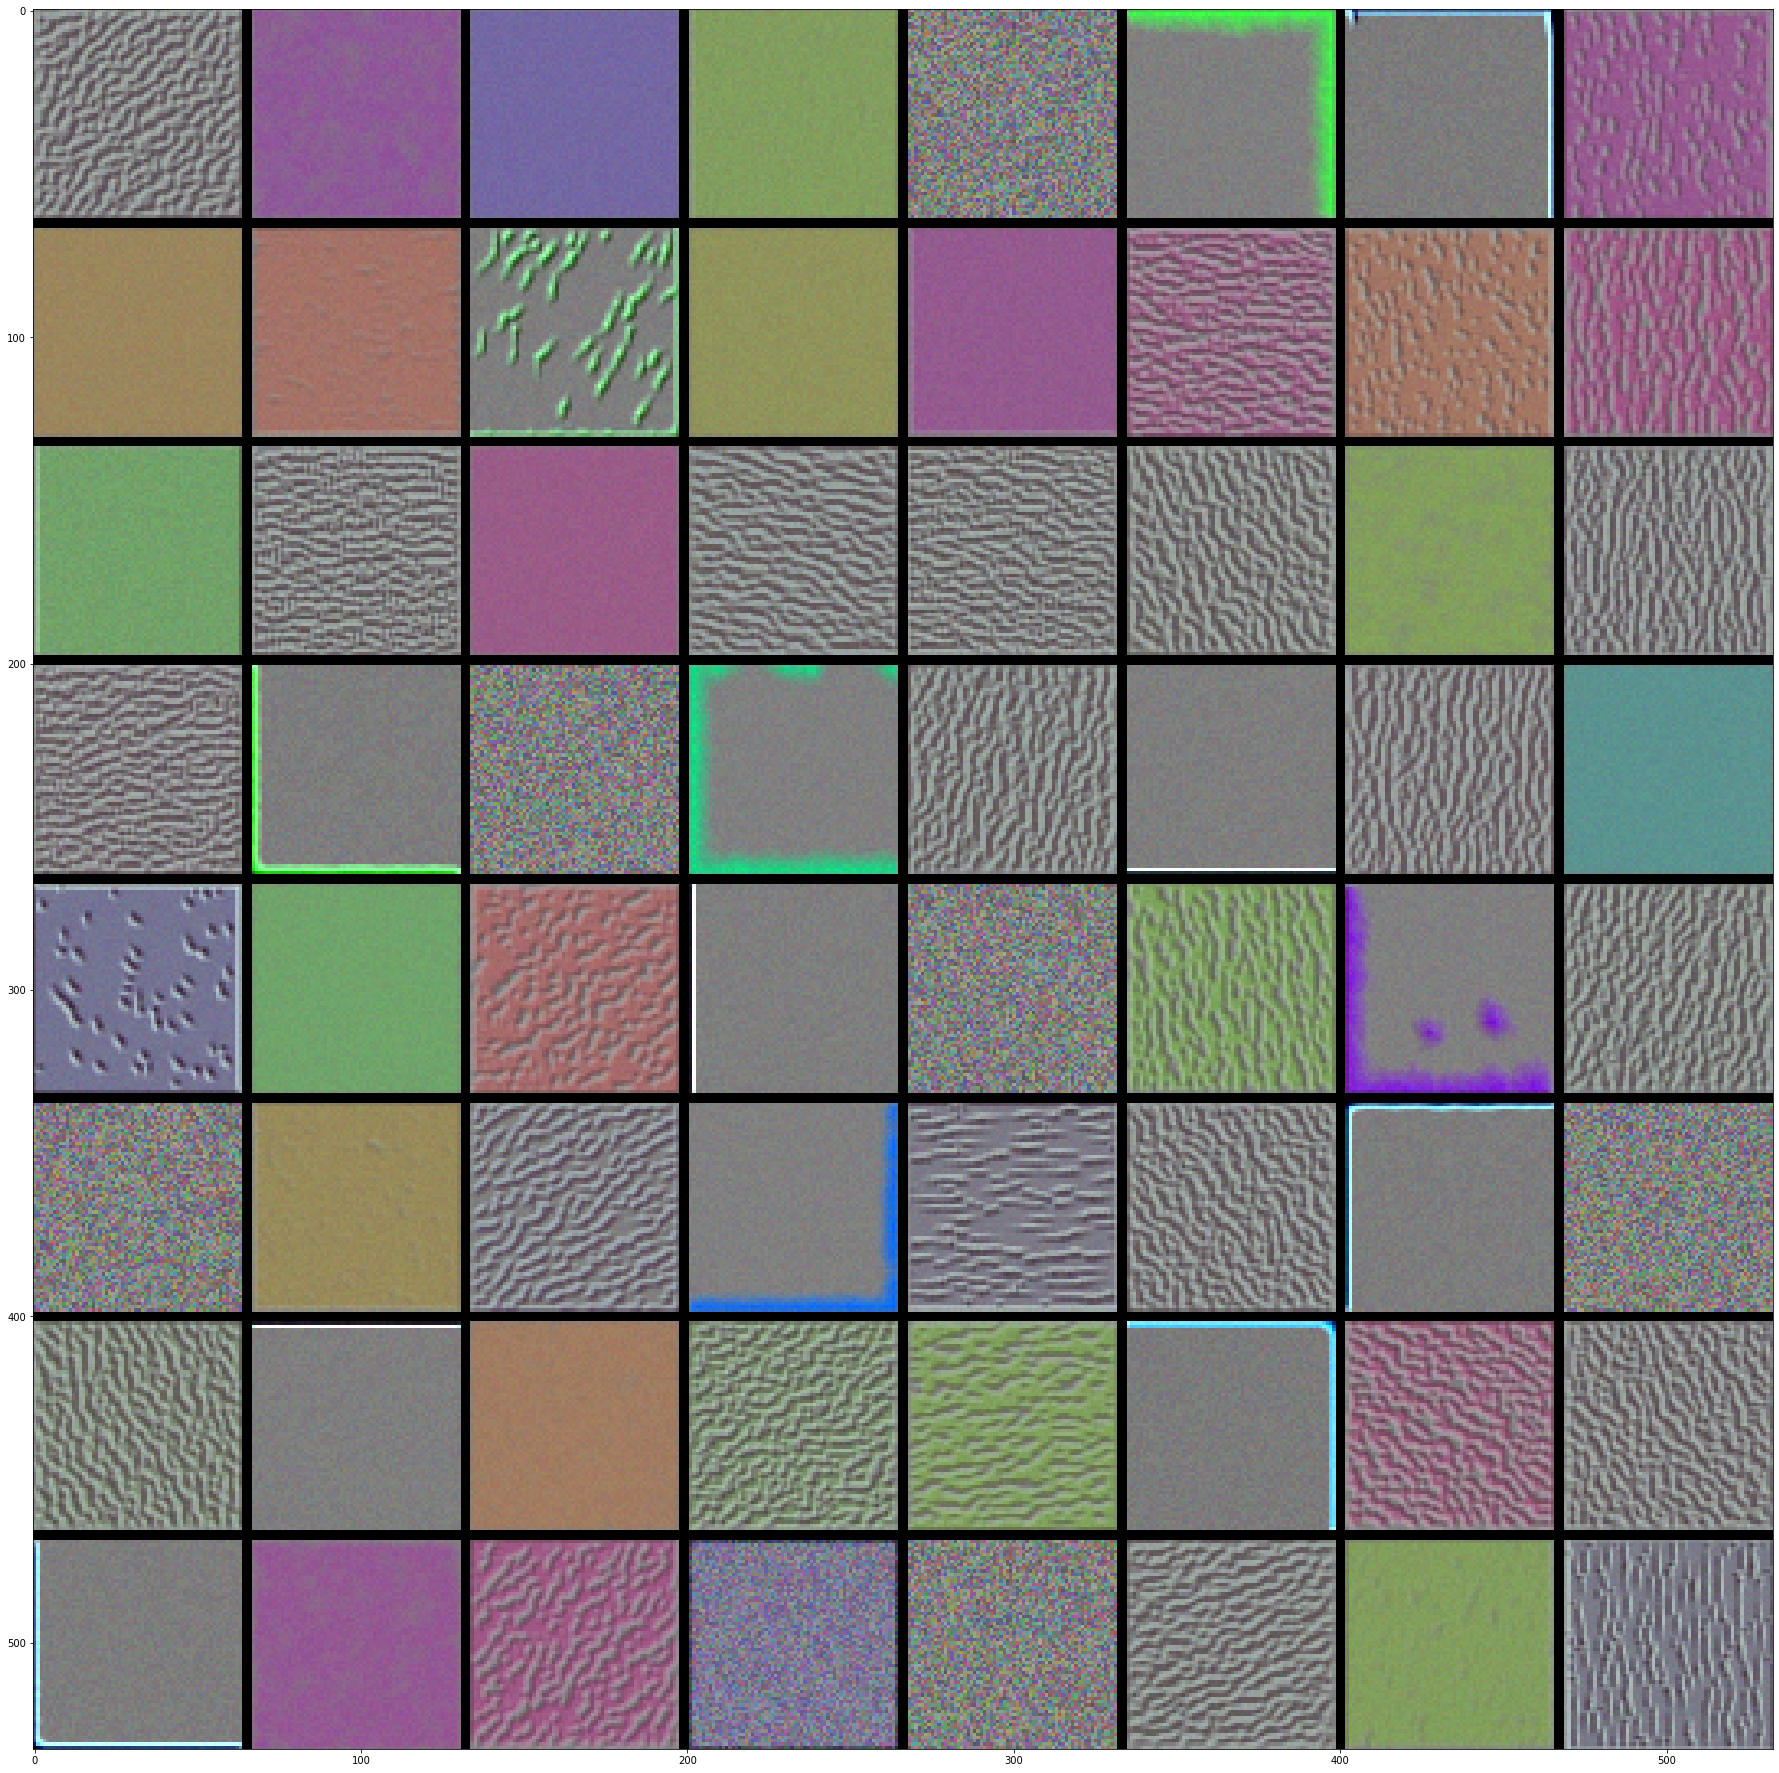

Layer name: block1_conv2


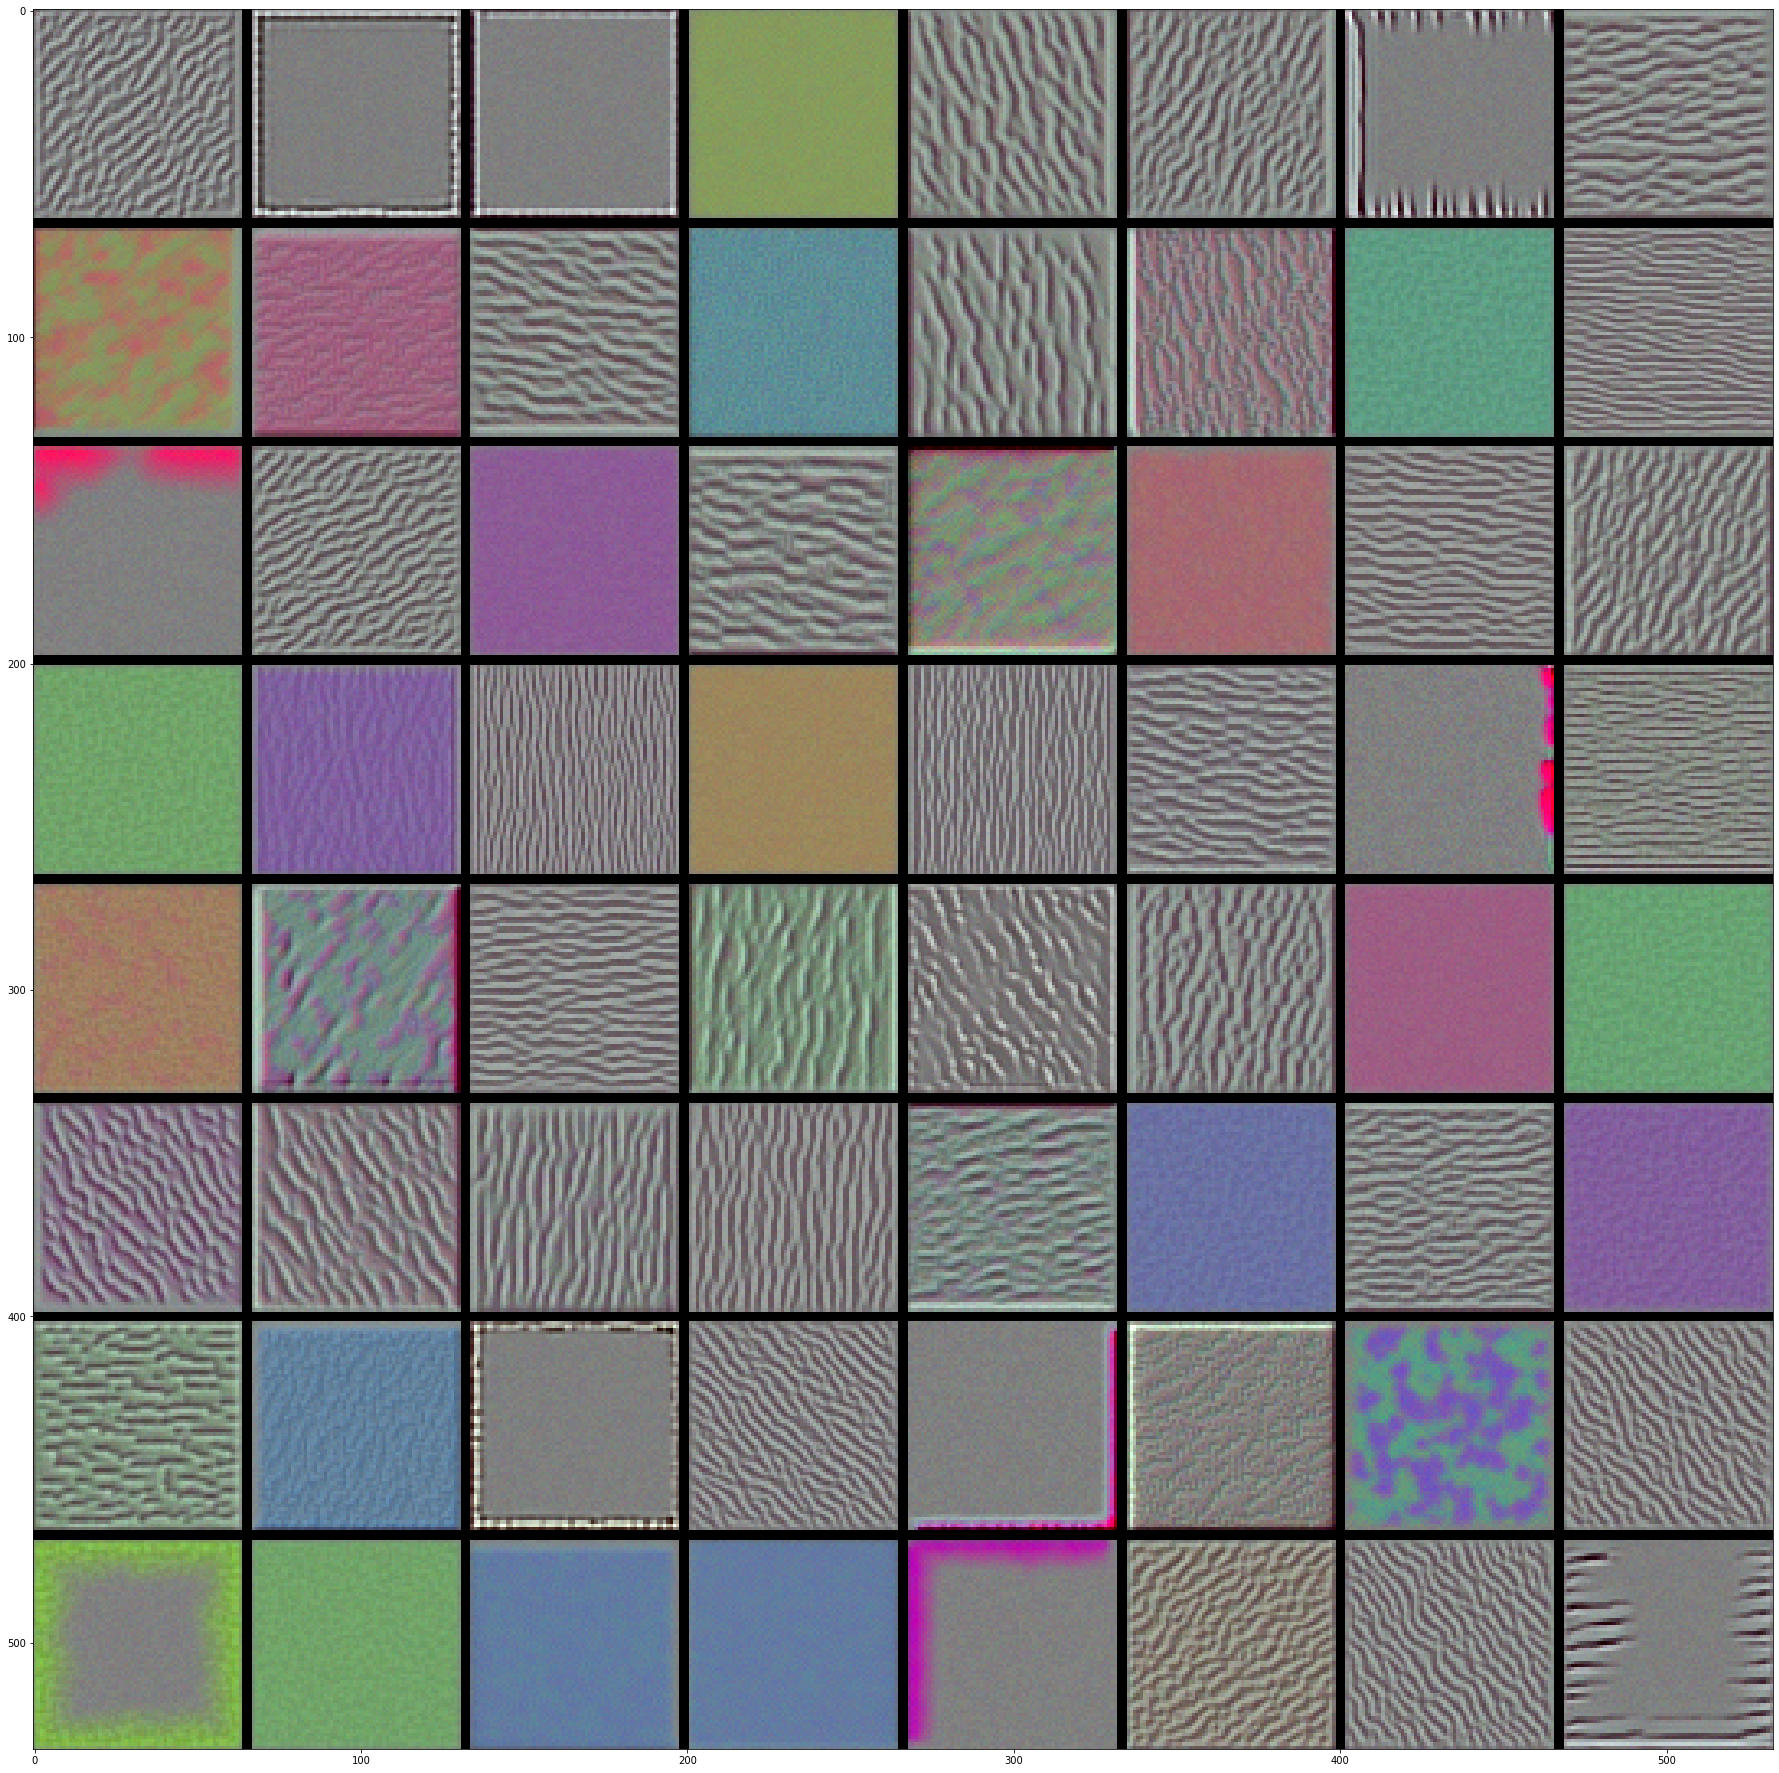

Layer name: block2_conv1


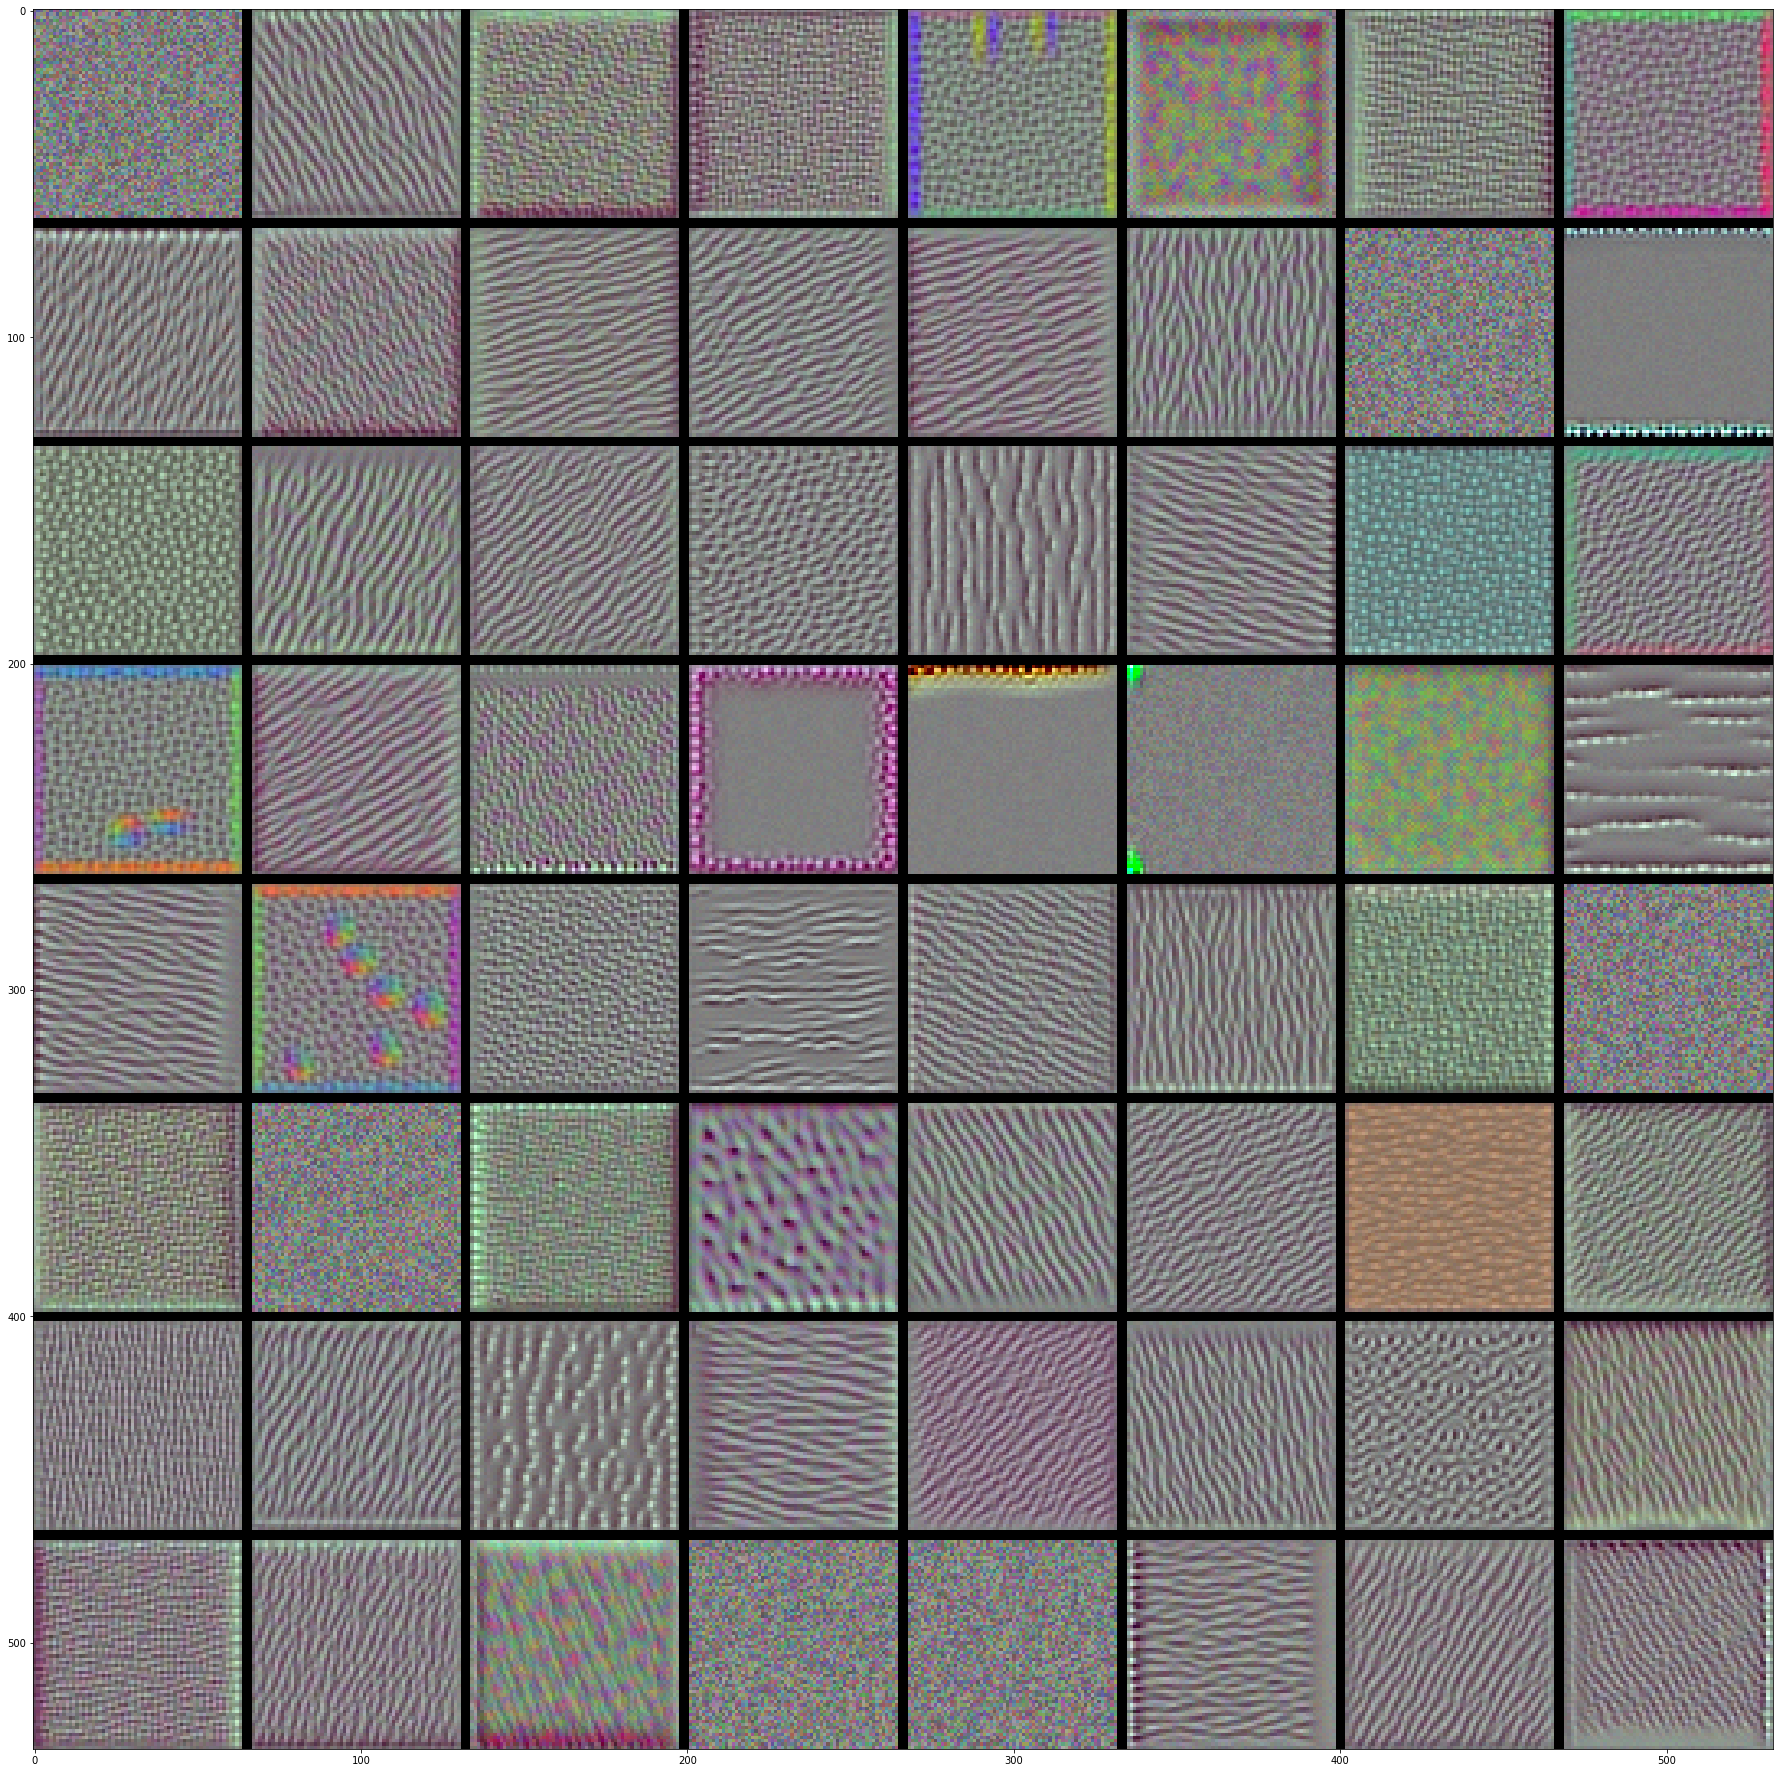

Layer name: block2_conv2


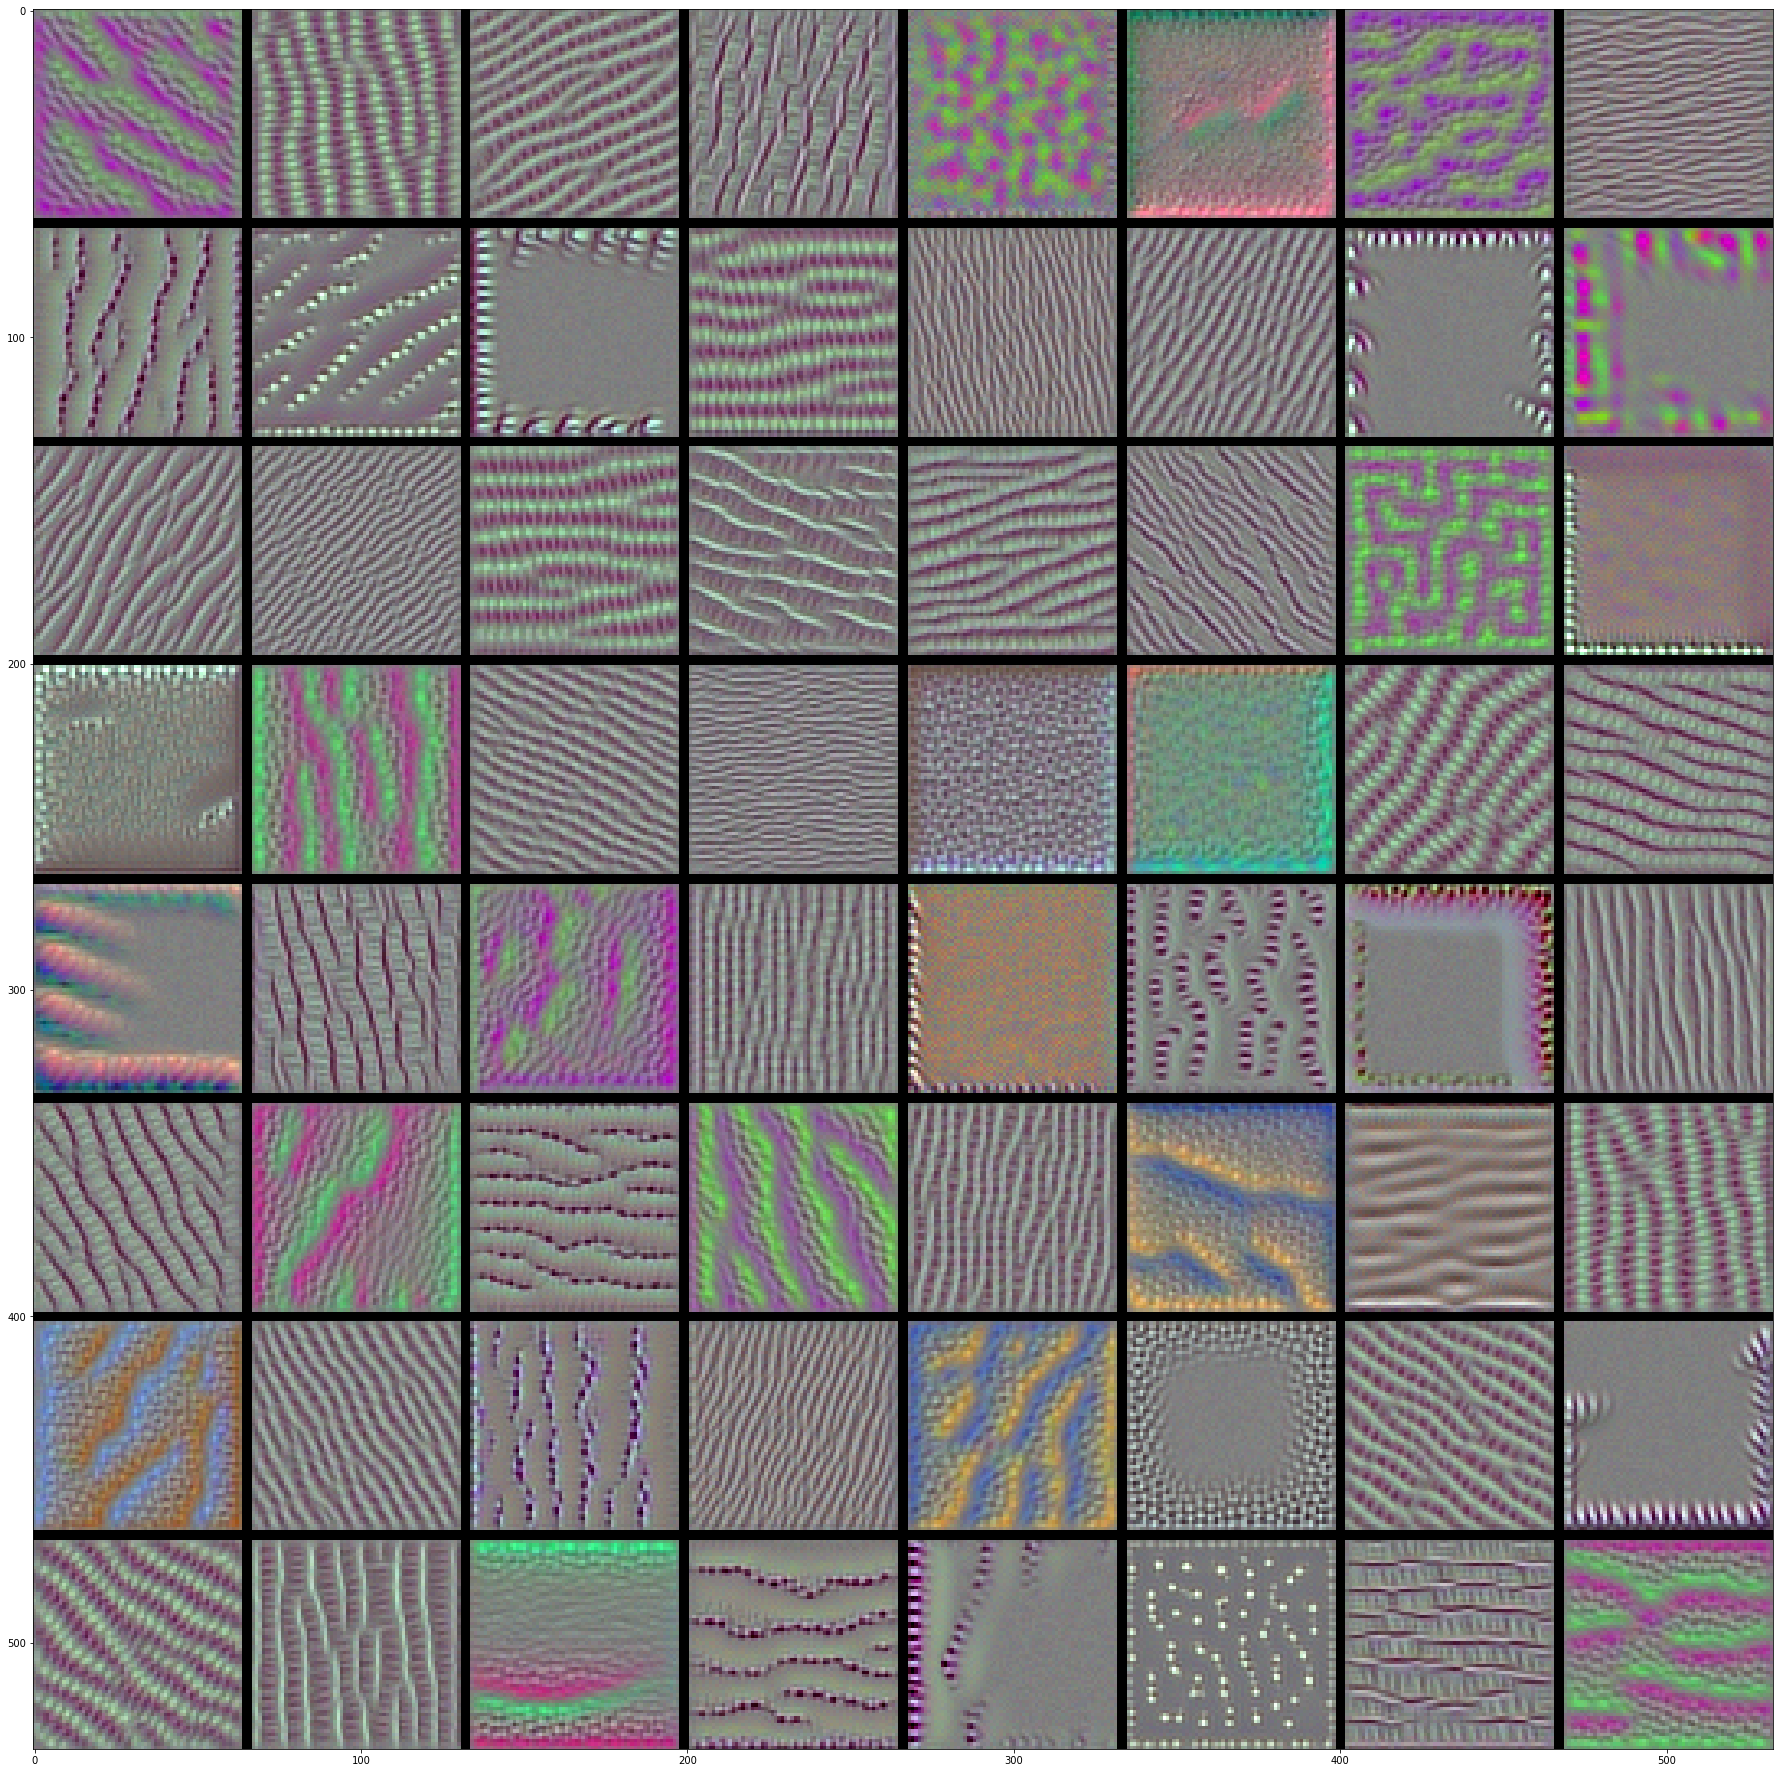

KeyboardInterrupt: ignored

In [ ]:

size = 64
margin = 3
no = 8

for layer_name in ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block4_conv1', 'block4_conv2', 'block5_conv1', 'block5_conv2']: 
    
    # This a empty (black) image where we will store our results.
    results = np.zeros((no * size + 7 * margin, no * size + 7 * margin, 3), dtype=np.uint8)

    for i in range(no):  # iterate over the rows of our results grid
        for j in range(no):  # iterate over the columns of our results grid
            filter_img = generate_pattern(layer_name, i + (j * no), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start : horizontal_end, vertical_start : vertical_end, : ] = filter_img

    # Display the results grid
    print("Layer name: " + layer_name)
    plt.figure(figsize=(size / 2, size / 2))
    plt.imshow(results)
    plt.show()


In [ ]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top; all previous times, we were discarding it.
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_IR.h5')

In [ ]:
def show_heat_map(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    african_elephant_output = model.output[:, np.argmax(preds[0])]
    last_conv_layer = model.get_layer('conv2d_29')
    grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    plt.imshow(heatmap)
    plt.show()

    superimposed_img = heatmap * 0.3 + img
    superimposed_img = superimposed_img.astype('uint8')

    plt.imshow(superimposed_img)
    plt.show()

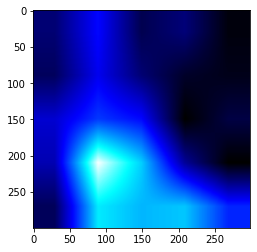

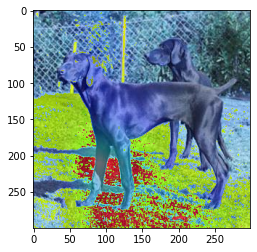

In [ ]:
show_heat_map('/content/drive/MyDrive/test_dog_image.jpg')

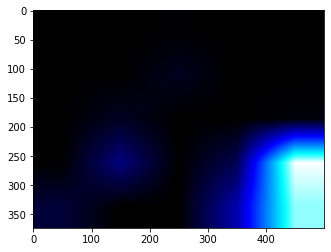

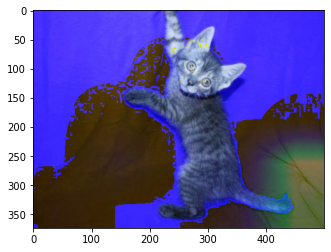

In [ ]:
show_heat_map('/content/drive/test_cat_image.jpg')

# Wnioski:
Model uległ przeuczeniu, a decyzje podejnowane są na podstawie losowych elementów obrazu. Widać wielkość zbioru danych jest istotnym elementem nauki. Pies został najprawdopodobniej rozpoznany za pomocą trawy, natomiast kot za pomocą materiału.




In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/animal_IR.h5')

In [ ]:
horse = load_image_custom('/content/drive/MyDrive/test_horse_image.jpeg')
elephant = load_image_custom('/content/drive/MyDrive/test_elephant_image.jpg')

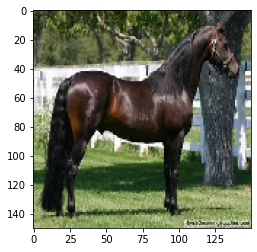

In [ ]:
plt.imshow(horse[0])
plt.show()

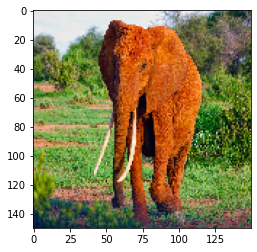

In [ ]:
plt.imshow(elephant[0])
plt.show()

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
<ipython-input-6-ca96188834be>:39: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


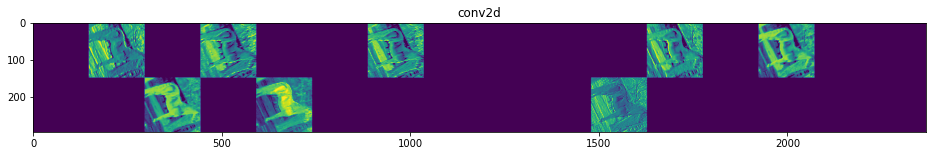

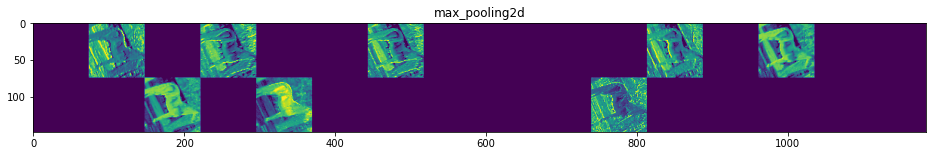

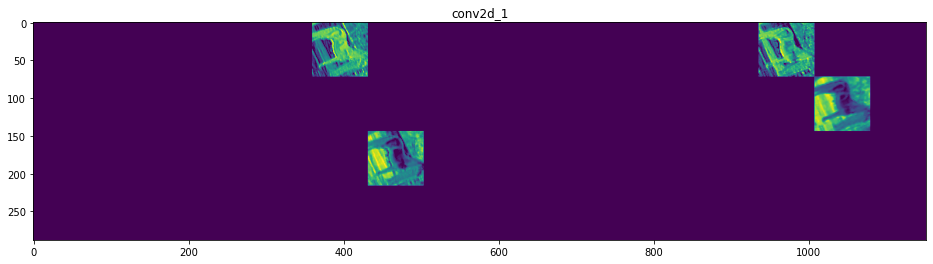

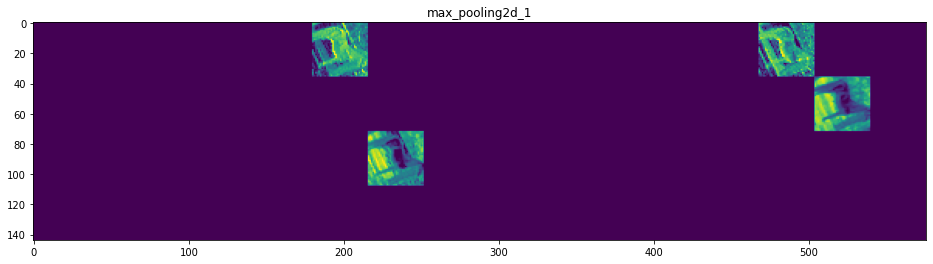

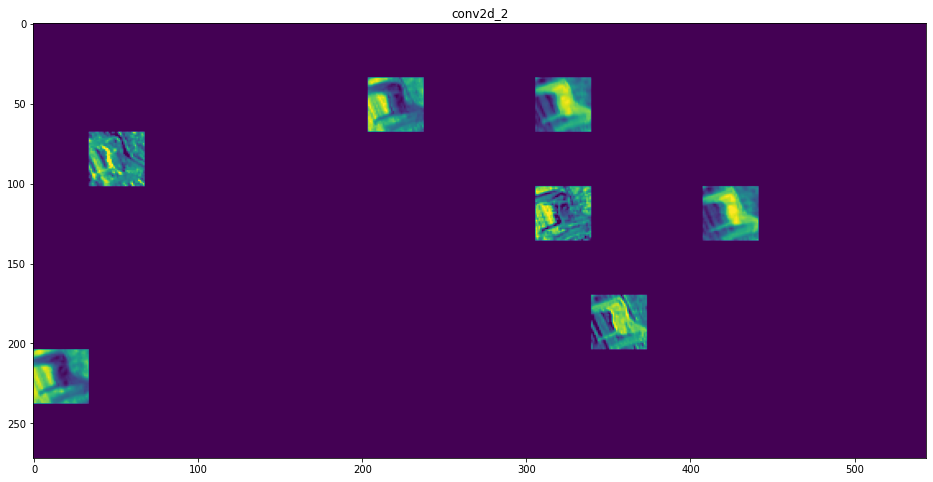

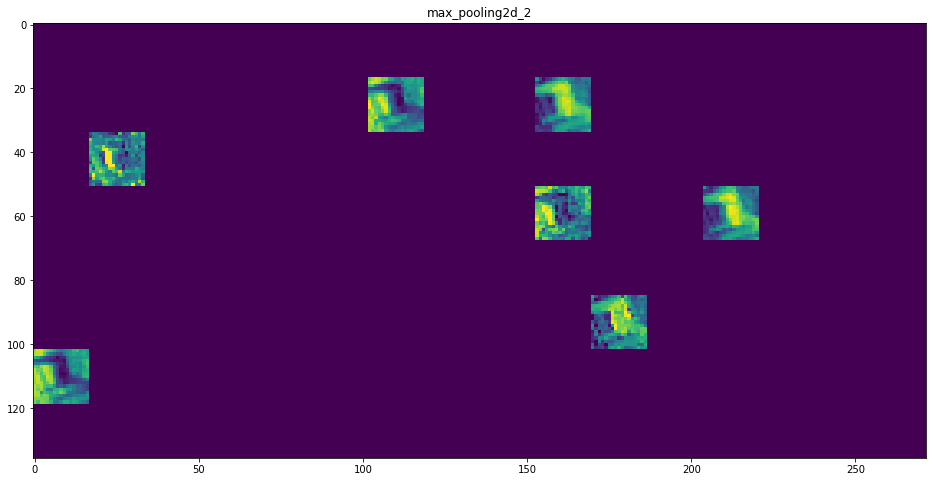

In [ ]:
show_layers(horse)

<ipython-input-6-ca96188834be>:39: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


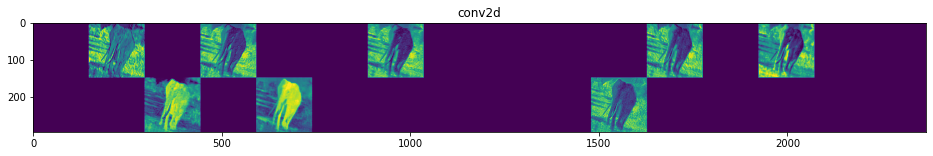

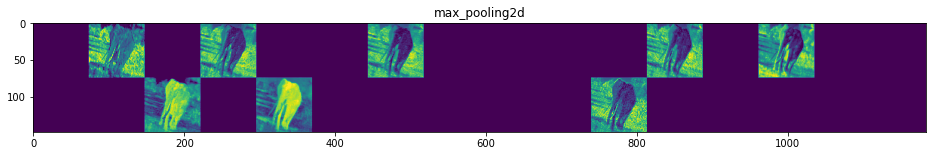

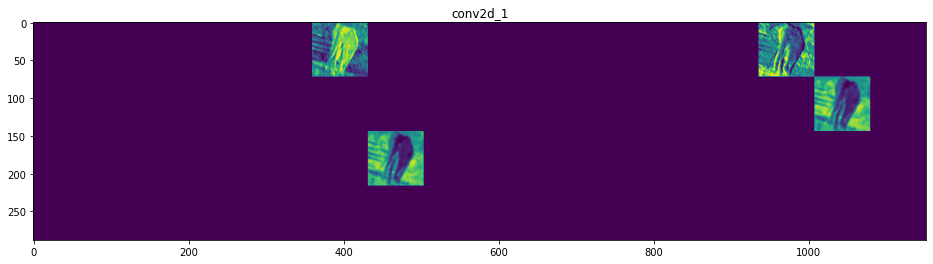

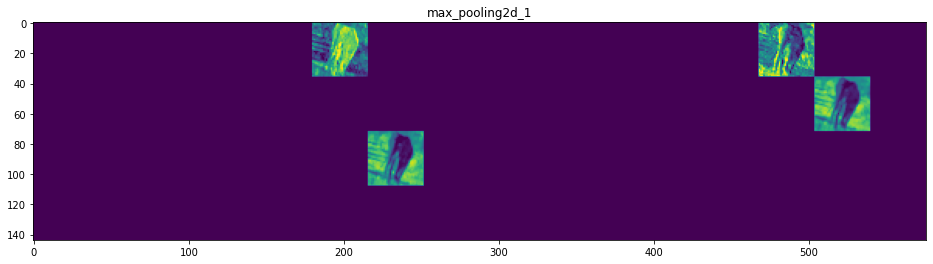

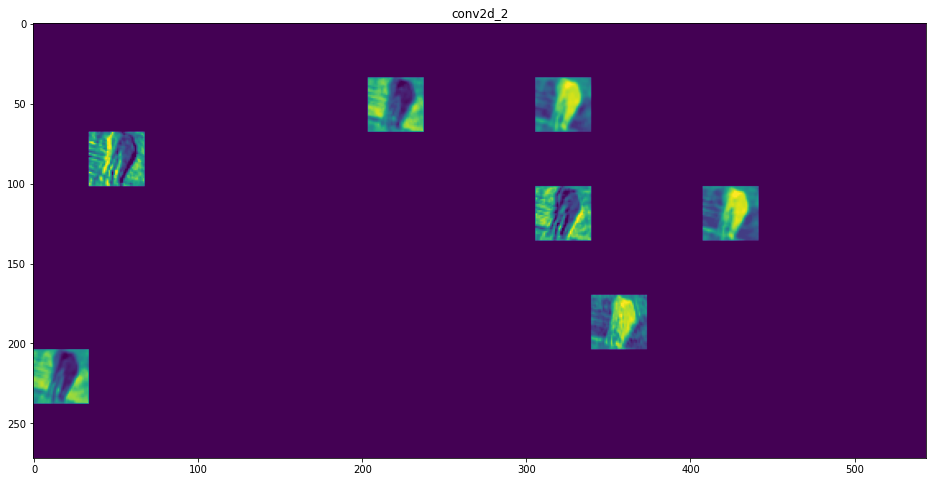

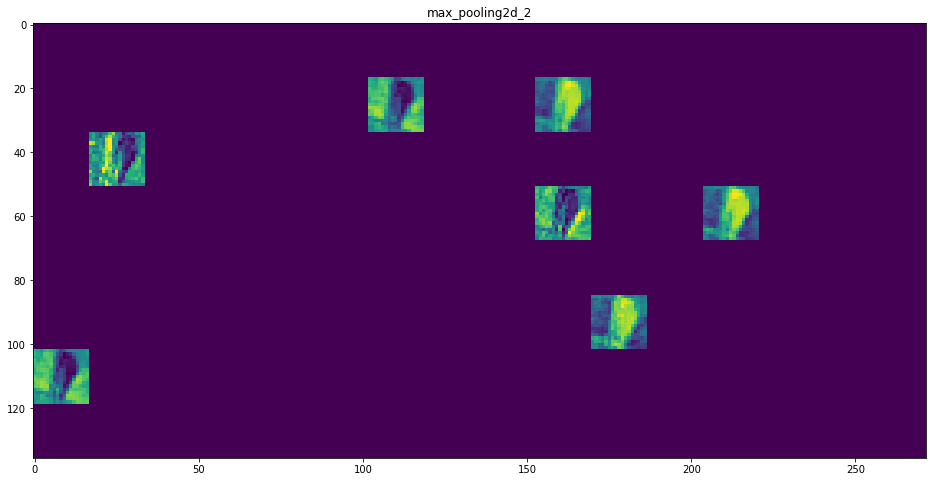

In [ ]:
show_layers(elephant)

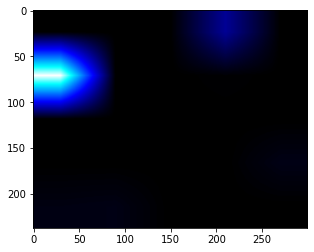

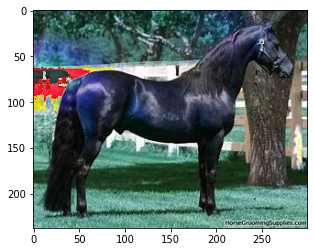

In [ ]:
show_heat_map('/content/drive/MyDrive/test_horse_image.jpeg')

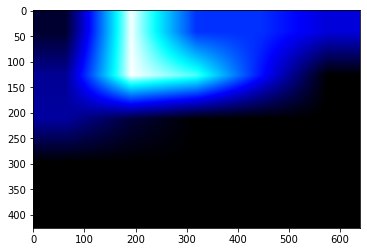

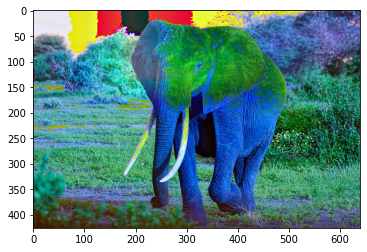

In [ ]:
show_heat_map('/content/drive/MyDrive/test_elephant_image.jpg')

# Wnioski 
Aktywowane są te same filtry dla rozpoznania konia i słonia.
Aktywacji podlegają:
  - 8/32
  - 4/64
  - 7/128
filtrów.

Heatmapy, z uwagi na obrót obrazów (podyktowany najnowszym zalecanym sposobem augmentacji danych) są nieczytelne. 
Z uwagi na bardzo mały zbiór danych efekty nauki, a raczej efekt jej interpretacji jest niezadowalający.